In [1]:
%matplotlib inline

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import vaex
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np
import multiprocessing
from tqdm import tqdm
import time

In [3]:
n = 10**7
a = np.arange(n)
b = np.arange(n, 2*n)
c = np.arange(2*n, 3*n)
vx_df = vaex.from_arrays(a=a, b=b, c=c)

In [4]:
file = './data/test_10_7_ops.hdf5'
vx_df.export(file, progress=True, shuffle=True)

[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
      

In [5]:
vx_df = vaex.open(file)
vx_df.executor.buffer_size = len(vx_df) // (multiprocessing.cpu_count() * 2)
pd_df = vx_df.to_pandas_df()
dd_df = dd.from_pandas(pd_df, npartitions=4)

In [6]:
def timeit(expr, n, scope):
    times = []
    for i in range(n):
        s = time.time()
        eval(expr, scope)
        e = time.time()
        times.append(e - s)

    return times

In [8]:
methods = {
	'plus': 'df["a"] + df["b"]',
    'minus': 'df["a"] - df["b"]',
    'mult': 'df["a"] * df["b"]',
    'div':  'df["a"] / df["b"]',
}

In [14]:
n = 3

performances = {}
for name, expr in tqdm(methods.items()):
    # daskはcompute()で評価
    dask_expr = expr + ".compute()"
    
    # nop() はevaluateして結果を捨てるベンチマーク用のメソッド
    vaex_expr = expr + ".nop()" 

    t_pd = timeit(expr, n, scope={'df': pd_df})
#     t_dd = timeit(dask_expr, n, scope={'df': dd_df})
    t_vx = timeit(vaex_expr, n, scope={'df': vx_df})
    
    performance = {
        'pandas': t_pd,
#         'dask': t_dd,
        'vaex': t_vx
    }
    print(performance)
    performances[name] = performance

 50%|█████     | 2/4 [00:00<00:00,  6.89it/s]

{'pandas': [0.0466766357421875, 0.045812368392944336, 0.0456995964050293], 'vaex': [0.0026144981384277344, 0.002197742462158203, 0.0021588802337646484]}
{'pandas': [0.045745134353637695, 0.04561281204223633, 0.045554399490356445], 'vaex': [0.002500772476196289, 0.002172231674194336, 0.002171039581298828]}


 75%|███████▌  | 3/4 [00:00<00:00,  6.86it/s]

{'pandas': [0.046497344970703125, 0.046605587005615234, 0.046588897705078125], 'vaex': [0.0026090145111083984, 0.0021703243255615234, 0.002577543258666992]}


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

{'pandas': [0.06768250465393066, 0.06771397590637207, 0.06767439842224121], 'vaex': [0.0025482177734375, 0.002294301986694336, 0.002251148223876953]}


In [15]:
dfs = []
for name, p in performances.items():
    tmp_df = pd.DataFrame(p).stack()
    tmp_df = tmp_df.reset_index()
    tmp_df = tmp_df.rename(columns={"level_0": "n", "level_1": "type", 0: "time"})
    tmp_df['method'] = name
    dfs.append(tmp_df)

dfp = pd.concat(dfs)

import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="pastel")

Text(0, 0.5, '')

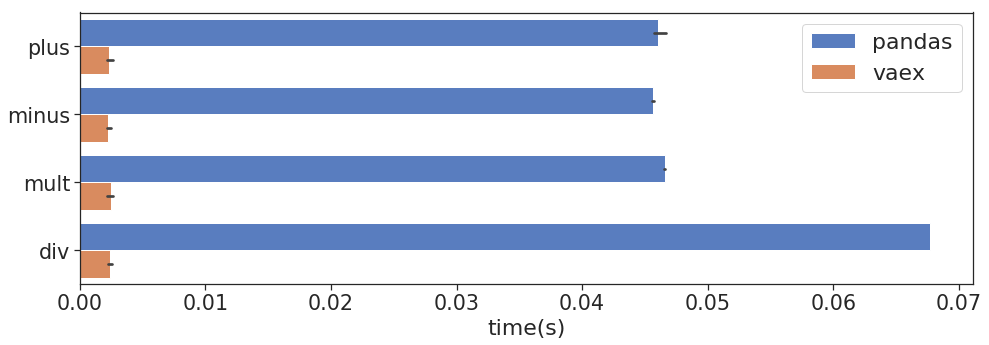

In [16]:
plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=dfp, y="method", x="time", hue="type", palette="muted"
)
ax.tick_params(axis='both', labelsize='xx-large')
ax.legend(fontsize=22)
ax.set_xlabel('time(s)', fontsize=22)
ax.set_ylabel('')

In [39]:
pd.pivot_table?

In [41]:
dfp_c = dfp.groupby(['type', 'method'])['time'].mean().reset_index().pivot_table(values='time', columns='type', index='method')

In [43]:
(dfp_c['pandas'] / dfp_c['vaex']).mean()

133.621008212719